## Пример кластеризации на реальных данных
В этом примере мы рассмотрим применение метода K-means к реальным данным. Согласно описанию, объекты — люди возраста 18 лет. Каждый объект обладает тремя атрибутами: Пол (Gender), Рост (Height) и Вес (Weight). Для начала подключим необходимые библиотеки.

In [7]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import os
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing

Импортируем датасет в датафрейм и проверим, все ли корректно импортировалось. 

<b>Примечание:</b> Изначально рост был указан в дюймах, а вес -- в фунтах. Для удобства восприятия значения были переведены в сантиметры и килограммы, соответственно.

In [8]:
df = pd.read_csv("height-weight_metric.csv", sep=";", decimal='.', index_col='id')
df.head()

,Gender,Height,Weight
id,,,
1,Male,187.571423,109.720985
2,Male,174.706036,73.622732
3,Male,188.239668,96.497550
4,Male,182.196685,99.809504
5,Male,177.499761,93.598619


Поскольку каждый объект имеет всего три признака, вполне возможно построить график в 3d. Для этого сначала сделаем признак <code>Gender</code> числовым (женщинам поставим в соответствие 0, мужчинам — 1).

C:\Users\makar\AppData\Local\Temp\ipykernel_78920\950073717.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].replace('Female', 0, inplace = True)
C:\Users\makar\AppData\Local\Temp\ipykernel_78920\950073717.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

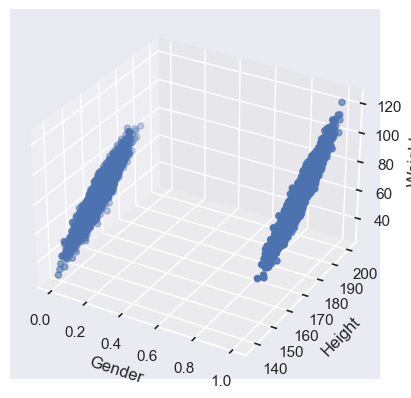

In [9]:
### 3d построение
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")
df['Gender'].replace('Female', 0, inplace = True)
df['Gender'].replace('Male', 1, inplace = True)
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['Gender']
y = df['Height']
z = df['Weight']

ax.set_xlabel("Gender")
ax.set_ylabel("Height")
ax.set_zlabel("Weight")
ax.scatter(x, y, z)
plt.show()

Нетрудно заметить, что объекты явно можно разделить на 2 кластера по половому признаку. Это было очевидно с самого начала, поэтому попробуем на пол пока что внимания не обращать (исключим его из предикторов).

<Axes: xlabel='Height', ylabel='Weight'>

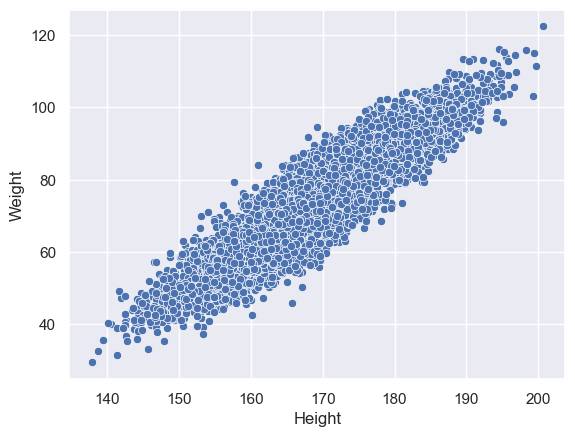

In [10]:
df_no_gender = df.drop(columns = 'Gender')
sns.scatterplot(data = df_no_gender, x = "Height", y = "Weight")

Выбросов не видно. Данные имеют разные единицы измерения, стандартизуем их. Используем линейную нормировку (MinMaxScaler).

<Axes: xlabel='Height', ylabel='Weight'>

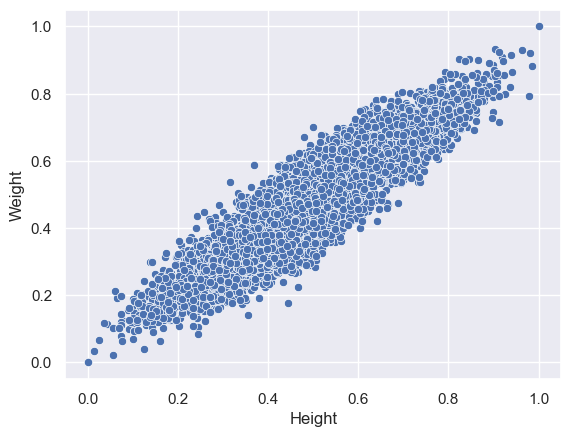

In [11]:
stand = preprocessing.MinMaxScaler()
X = stand.fit_transform(df_no_gender)
X = pd.DataFrame(X, index = df_no_gender.index, columns = df_no_gender.columns)
sns.scatterplot(data = X, x = "Height", y = "Weight")

Теперь нужно определиться с количеством кластеров. Построим график каменистой осыпи.

In [12]:
from sklearn.cluster import KMeans
from tqdm import tqdm

# Рассмотрим число кластеров с запасом
K = range(1, 31)

# Для каждого k будет построено 10 моделей, выбирается в итоге лучшая (меньшая сумма внутрикластерных расстояний, значение inertia_).
# Начальная инициализация по умолчания производится методом k-means++
dist = [KMeans(n_clusters = k, random_state = 1, n_init = 10).fit(X).inertia_ for k in tqdm(K)]
rock_line = pd.DataFrame()
rock_line[r'$K$ - число кластеров'] = K
rock_line[r'$Q_{final}(K)$'] = dist

100%|██████████| 30/30 [00:12<00:00,  2.47it/s]


Text(0.5, 1.0, 'График каменистой осыпи')

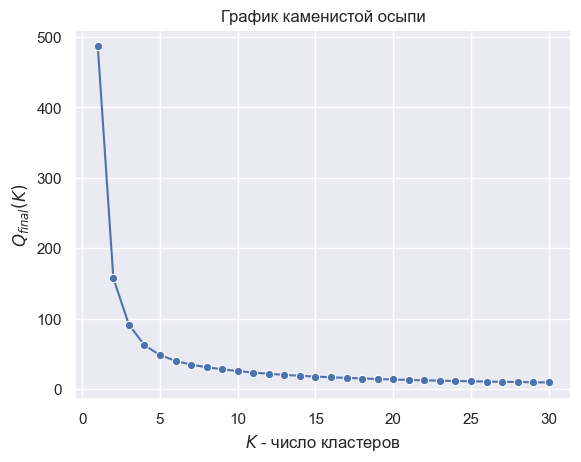

In [13]:
sns.lineplot(data = rock_line, x = r"$K$ - число кластеров", y = r"$Q_{final}(K)$", markers = True, marker = 'o').set_title('График каменистой осыпи')

Рассмотрим более детально случаи до 10 кластеров.

100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


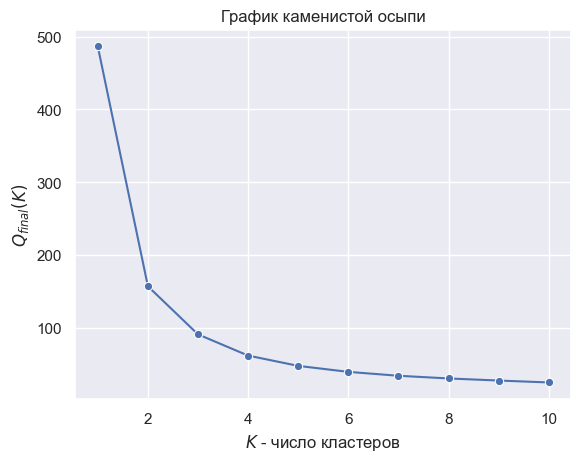

In [14]:
K = range (1, 11)

# Строим 10 моделей с разным числом кластеров. Качество кластеризации содержится в model.inertia_
dist = [KMeans(n_clusters = k, random_state = 1, n_init = 10).fit(X).inertia_ for k in tqdm(K)]
rock_line = pd.DataFrame()
rock_line[r'$K$ - число кластеров'] = K
rock_line[r'$Q_{final}(K)$'] = dist
lnplt = sns.lineplot(data = rock_line, x = r"$K$ - число кластеров", y = r"$Q_{final}(K)$", markers = True, marker = 'o').set_title('График каменистой осыпи')
lnplt = lnplt.get_figure()    
lnplt.savefig('rock_line_example_2.png', dpi=400)

Можно заметить, что график начинает быть более пологим, начиная с отметки в четыре кластера. Значит, попробуем разбить на четыре кластера.

In [15]:
#Добавим в данные графу "кластер" и посмотрим
model = KMeans(n_clusters = 4, random_state = 1, n_init=10)
model.fit(X)
df_no_gender['Cluster'] = model.labels_
df_no_gender.groupby('Cluster').mean()

,Height,Weight
Cluster,,
0,164.273425,65.838670
1,172.587676,80.303390
2,155.260150,53.678319
3,182.139021,92.996835


Что же у нас получилось?


*   0 — 164 см, 66 кг — люди невысокого роста (в эту категорию, скорее всего, в основном отнесены женщины; впрочем, сюда могут быть отнесены и невысокие мужчины);
*   1 — 173 см, 80 кг — скорее всего мужчины среднего роста и относительно крупные женщины;
*   2 — 155 см, 53 кг — в основном женщины обычной комплекции (возможно, некоторые совсем некрупные мужчины);
*   3 — 182 см, 93 кг — скорее всего крупные мужчины, не исключены и совсем крупные женщины.

Построим график.

<Axes: xlabel='Height', ylabel='Weight'>

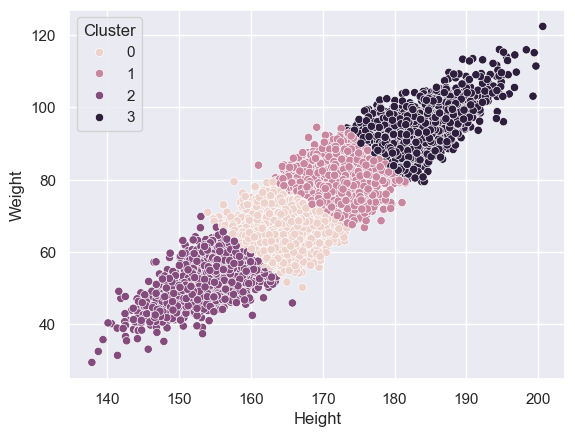

In [16]:
sns.scatterplot(data = df_no_gender, x = "Height", y = "Weight", hue = 'Cluster')

Проверим наши предположения, а именно включим признак "Пол"

In [17]:
df['Cluster'] = model.labels_
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,0.184088,164.273425,65.838670
1,0.805816,172.587676,80.303390
2,0.018621,155.260150,53.678319
3,0.991076,182.139021,92.996835


Мы оказались правы, действительно, кластер 0 состоит из порядка 20 процентов некрупных мужчин, в кластере 1 -- порядка 20 процентов относительно крупных женщин. Кластеры 2 и 3 практически моногендерны.

Рассмотрим случай с тремя кластерами.

In [18]:
model = KMeans(n_clusters = 3, random_state = 1, n_init=10)
model.fit(X)
df_no_gender['Cluster'] = model.labels_
df_no_gender.groupby('Cluster').mean()

,Height,Weight
Cluster,,
0,179.976223,90.392961
1,157.877777,57.015680
2,168.874068,73.778786


<Axes: xlabel='Height', ylabel='Weight'>

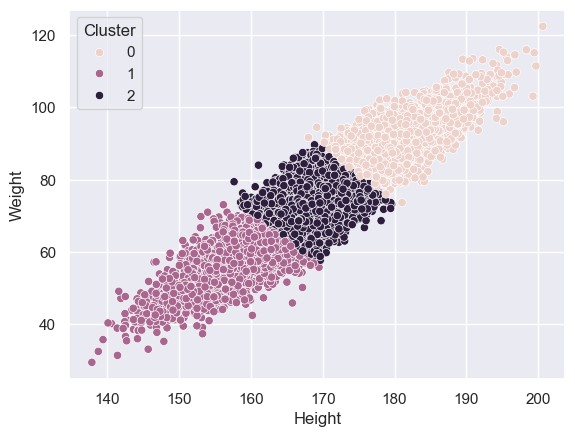

In [19]:
sns.scatterplot(data=df_no_gender, x="Height", y="Weight", hue = 'Cluster')

В таком случае имеем:

*   0 — стандартные люди. Средний рост, средний вес;
*   1 — высокие, крупные люди;
*   2 — миниатюрные люди.

Добавим в процесс кластеризации пол. Поскольку пол обозначается числами 0 или 1, то в результате линейной нормировки эти значения сохранятся, поэтому просто добавим к нашему нормированному набору данных X столбец <code>Gender</code>.

In [20]:
X['Gender'] = df['Gender']
X.head()

,Height,Weight,Gender
id,,,
1,0.791728,0.863139,1
2,0.586958,0.475476,1
3,0.802364,0.721131,1
4,0.706182,0.756699,1
5,0.631424,0.689999,1


Проведем аналогичные процедуры, что и в предыдущем случае.

100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Text(0.5, 1.0, 'График каменистой осыпи')

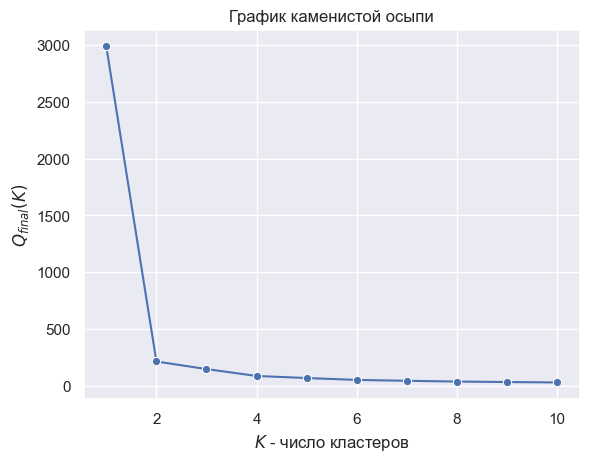

In [21]:
K = range (1, 11)

# Строим 10 моделей с разным числом кластеров. Качество кластеризации содержится в model.inertia_
dist = [KMeans(n_clusters = k, random_state = 1, n_init = 10).fit(X).inertia_ for k in tqdm(K)]
rock_line = pd.DataFrame()
rock_line[r'$K$ - число кластеров'] = K
rock_line[r'$Q_{final}(K)$'] = dist
sns.lineplot(data = rock_line, x = r"$K$ - число кластеров", y = r"$Q_{final}(K)$", markers = True, marker = 'o').set_title('График каменистой осыпи')

Очевидно разделение на два кластера, хотя можно заподозрить и четыре.

In [22]:
model = KMeans(n_clusters = 2, random_state = 1, n_init=10)
model.fit(X)
df['Cluster'] = model.labels_
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,1.0,175.326919,84.831057
1,0.0,161.820285,61.625051


Четкое разделение на женщин и мужчин.

А если попробовать три кластера?

In [23]:
model = KMeans(n_clusters = 3, random_state = 1, n_init=10)
model.fit(X)
df['Cluster'] = model.labels_
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,1.0,169.601532,77.997893
1,0.0,161.820285,61.625051
2,1.0,180.925477,91.512854


Мужчины разделились на два кластера: пониже и повыше.

А если все же четыре?

In [24]:
model = KMeans(n_clusters = 4, random_state = 1, n_init=10)
model.fit(X)
df['Cluster'] = model.labels_
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,1.0,180.925477,91.512854
1,0.0,167.251864,68.193901
2,1.0,169.601532,77.997893
3,0.0,156.542915,55.242699


Теперь явно девушки разбились на два кластера: совсем миниатюрные и средние. Мужчины почти не изменились.

 С учетом пола график кластеризации будет выглядеть следующим образом.

<Axes: xlabel='Height', ylabel='Weight'>

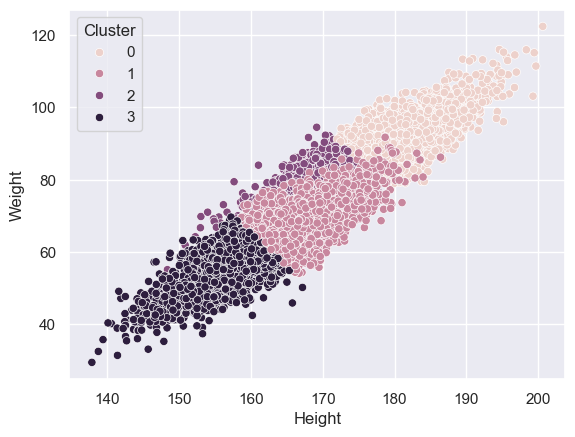

In [25]:
sns.scatterplot(data = df, x = "Height", y = "Weight", hue = 'Cluster')